    Python/Jupyter Notebook version 6.0.3

In [1]:
# Importing modules

%matplotlib inline  
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from functools import reduce
import statsmodels.api as sm
import statsmodels.stats
import scipy as sp 
from scipy import stats

# Setting up random seed
np.random.seed(100)

plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size

## A

In [2]:
# import data
data = pd.read_csv("randomX.csv")

# add a column which is x3**2
data['x3_2'] = data['x3']**2

# check that column is added 
data.head()

,x1,x2,x3,x3_2
0,0.537667,0.840376,0.183227,0.033572
1,1.833885,-0.888032,-1.029768,1.060421
2,-2.258847,0.100093,0.949222,0.901022
3,0.862173,-0.544529,0.307062,0.094287
4,0.318765,0.303521,0.135175,0.018272


#### Monte Carlo Simulations function

True DGP: 𝑌𝑖 = 𝛽0 + 𝛽1𝑋1,𝑖 + ε𝑖

We simulate data for True DGP and then use OLS to estimate the given model 
𝑌𝑖 = 𝛽0 + 𝛽1𝑋1,𝑖 + 𝛽2𝑋2,𝑖 + β3𝑋3,𝑖 + 𝛽4𝑋3,𝑖 2 + 𝜀𝑖

In [3]:
def montecarlo(N,S,b0,b1,x1):          # N = sample size; S = number of simulations;
                                       # b0,b1 = coefficient for True DGP; x1 = column data csv file  
    Y = np.zeros((N,S))                # generate (S,N) zero-matrix to store y values
    
    for sims in range(S):              # loop through to simulate S Monte Carlo Simulations
        err = np.random.randn(N)       # generating N error terms for every simulation, in the end total err terms = N * S
        for i in range(N):             # loop through N number of times, N = len(x1)
            
            # True DGP
            y = b0 + b1*x1[i] + err[i]    # get y values for x1 and randomly generated err.
            Y[i,sims] = y             # replace zeros with y1 values
       
    return Y

#### OLS function

In [4]:
def ols(Y,X):    
    results = sm.OLS(Y, X).fit()           # OLS regression
    estimates = results.params             # Coefficient values from OLS regression
    rsquared = results.rsquared            # R-Squared values from OLS regression
    #summary = results.summary()
   
    # reshape values
    estimates = estimates.reshape(1,-1)
    rsquared = rsquared.reshape(1,-1)
    
    # putting values in one array
    ols_results = np.concatenate((estimates,rsquared), axis=1)
    
    return ols_results
    


In [5]:
# function to add ones as constant
def addones(array):
    ones = np.ones((np.shape(array)[0],1))    
    array = np.hstack((ones,array))
    return array

In [6]:
# define function for coefficient statistics
def coef_stats(array):
    
    # Create empty lists
    mean =[]
    se = []
    t_stat = [] 
    p_vals = []
    CI_lower = []
    CI_upper = []

    # loop to fill in values in the lists
    for i in range((np.size(array,1))): 
        
        # mean and standard error of coefficients & r-sqrd
        mean.append(np.mean(array[:,i]))
        se.append(np.std(array[:,i]))
    
        # t-statistic
        t_stat.append(np.abs(mean[i] / se[i]))

        # p-values
        p_vals.append(2*(1-stats.norm.cdf(t_stat[i])))
    
        # confidence intervals 95%
        CI_lower.append(mean[i] - 1.96 * se[i])
        CI_upper.append(mean[i] + 1.96 * se[i])
    
    return mean, se, t_stat, p_vals, CI_lower, CI_upper
    

#### Input for Monte Carlo simulation

In [7]:
S = 2000          # Number of Monte Carlo simulations
b0 = 0.5          # Value of beta_0
b1 = 1.5          # Value of beta_1

In [8]:
# Generate Y values using montecarlo 
Y = montecarlo(len(data['x1'].to_list()), S, b0, b1, data['x1'].to_list())

In [9]:
# X data
X = data[['x1','x2','x3','x3_2']]  

# add a constant to the independent X variables for OLS regression
X = addones(X)

# variable to store parameter coefficient and R-squared values
params = np.zeros((S,len(X[0])+1))  # required shape (2000,6)

# get parameter coefficient & R-sqrd values
for sims in range(S):
    
    # call function OLS
    results = ols(Y[:,sims],X)
        
    # store values in one array
    params[sims,:] = results[:]

#### i) Plot a histogram for each of the estimated parameters as well as the Rsquared. Into your histograms, also plot the corresponding median (of the respective parameter estimate/R-squared).

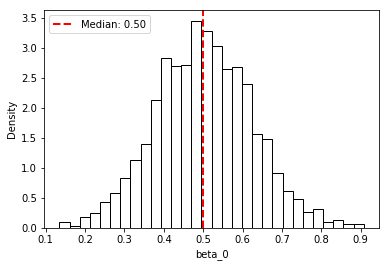

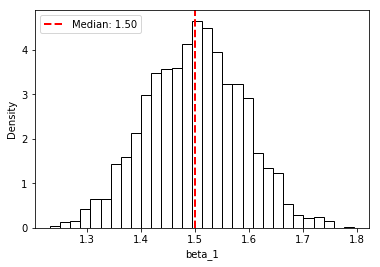

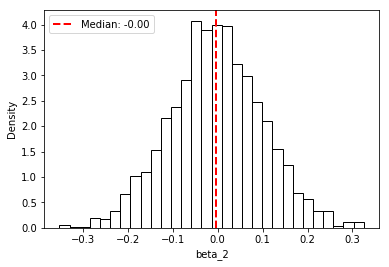

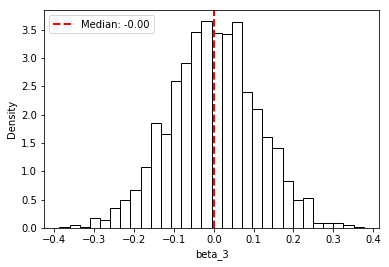

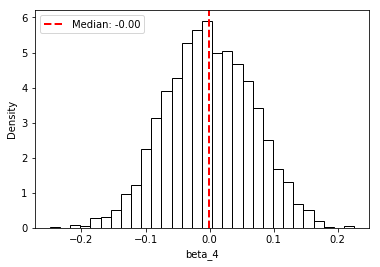

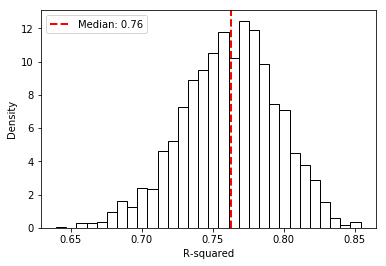

In [10]:
# Histogram plot names
names = ['beta_0','beta_1','beta_2','beta_3','beta_4','R-squared']

for i in range(len(names)): 
    
    # Plot histogram and median line
    result = plt.hist(params[:,i], density=True, edgecolor="black", facecolor = "none",bins=30)
    plt.axvline(np.median(params[:,i]), color='red', linestyle='dashed', linewidth=2, 
                label='Median: {:.2f}'.format(np.median(params[:,i])))
    
    plt.legend(loc='upper left'); plt.xlabel(str(names[i])); plt.ylabel('Density')
    plt.show()


#### ii) Construct 95% confidence intervals for each parameter based on the simulations. Which of the coefficients are significant?

In [11]:
# Coefficient statistics
mean, se, t_stat, p_vals, CI_lower, CI_upper = coef_stats(params)

# Create table to plot statistics
table1 = np.vstack((np.array(mean), np.array(se), np.array(t_stat), np.array(p_vals), np.array(CI_lower), np.array(CI_upper)))
table1 = pd.DataFrame(table1).T
table1.index = names
table1.columns = ['mean', 'se', 'T-stat', 'P-value', 'CI-lower', 'CI-upper']
table1

,mean,se,T-stat,P-value,CI-lower,CI-upper
beta_0,0.502704,0.122549,4.102071,0.000041,0.262508,0.742900
beta_1,1.499357,0.088846,16.875956,0.000000,1.325219,1.673495
beta_2,-0.003416,0.103605,0.032970,0.973699,-0.206481,0.199649
beta_3,-0.001831,0.110319,0.016597,0.986758,-0.218056,0.214395
beta_4,-0.000885,0.067907,0.013026,0.989607,-0.133982,0.132213
R-squared,0.761776,0.033463,22.764472,0.000000,0.696188,0.827364


Based on the model and the outcome, b0 and b1 coefficients gives significant p-values which means that we can reject the null hypothesis for b0 and b1 coefficients is equals 0 with a large degree of confidence. The T-statistic is large compared to other beta estimates. 

Note:
* We can not rescale the values since the we are using the errors that are drawn from the normal distribution with a variance of 1. 
* Also taking log of the x or the y values is not possible due to presence of negative terms for either variables.

#### iii) Redo the Monte Carlo experiment, but now estimate the true model structure for each simulation. Make a histogram of the estimate. How β1 does it compare to the one you produced in A.i? Do you find a difference? Provide an explanation why/why not.

Estimating the true model structure for each simulation 𝑌𝑖 = 𝛽0 + 𝛽1𝑋1,𝑖 + ε𝑖

In [12]:
# Number of MC simulations
S = 2000

# X and Y data
X = data[['x1']]

# add a constant to the independent X variables for OLS regression
X = addones(X)

# variable to store parameter coefficient and R-squared values
params = np.zeros((S,len(X[0])+1))  # required shape (2000,6)

# get parameter coefficient & R-sqrd values
for sims in range(S):
    
    # call function OLS
    results = ols(Y[:,sims],X)
        
    # store values in one array
    params[sims,:] = results[:]

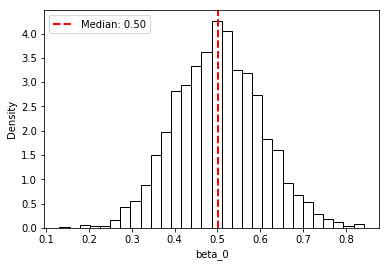

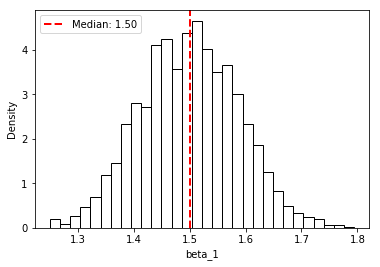

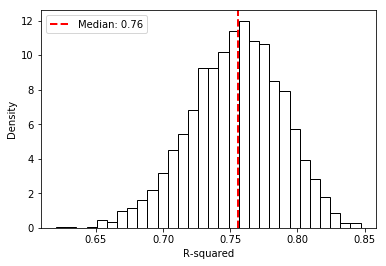

In [13]:
# Histogram plot names
names = ['beta_0','beta_1', 'R-squared']

# loop to plot histogram
for i in range(len(names)): 
    
    # Plot histogram and median line
    result = plt.hist(params[:,i], density=True, edgecolor="black", facecolor = "none",bins=30)
    plt.axvline(np.median(params[:,i]), color='red', linestyle='dashed', linewidth=2, label='Median: {:.2f}'.format(np.median(params[:,i])))
    
    plt.legend(loc='upper left'); plt.xlabel(str(names[i])); plt.ylabel('Density')
    plt.show()


In [14]:
# Coefficient statistics
mean, se, t_stat, p_vals, CI_lower, CI_upper = coef_stats(params)

# creating table
table1 = np.vstack((np.array(mean), np.array(se), np.array(t_stat), np.array(p_vals), np.array(CI_lower), np.array(CI_upper)))
table1 = pd.DataFrame(table1).T
table1.index = names
table1.columns = ['mean', 'se', 'T-stat', 'P-value', 'CI-lower', 'CI-upper']
table1

,mean,se,T-stat,P-value,CI-lower,CI-upper
beta_0,0.502271,0.100826,4.981578,6.306788e-07,0.304653,0.699889
beta_1,1.499102,0.087183,17.194944,0.000000e+00,1.328224,1.669981
R-squared,0.754145,0.034194,22.055062,0.000000e+00,0.687125,0.821165


Unbiased b1 estimates in both cases. We see very little or negligible difference in the mean values of b1 estimate as compared to what we observe in A.i. The significance does not change either. However, when we redo the Monte Carlo experiment and run the true model structure for each simulation, the SE value for b1 goes slightly down and T-statistic goes up slightly as compared to in A.i. Also we observe that the 95% confidence interval difference (CI_upper - CI_lower) is smaller now than before.

In part A.i we have more predictors. In the model on which we did OLS, beta_2, beta_3 and beta_4 values are insignificant as their p-values are very high due to low standard errors and very low T-statistic values. After removing these predictors, it did not have a major impact on the beta_1 coefficient in the true model. Though the R-squared value reduced slightly be reducing the number of predictors, but not considerably.
* Mathematically seem, error terms from the True DGP is distributed among the predictors x2, x3 & x4 and their respective coefficients. 
* Another observation is that the error mean is 0 and the coefficient means of beta_2, beta_3 & beta_4 are very small and closer to zero. 
* x2 and x3 are useless predictors that do not contribute much to the model and just adds to some noise.

#### iv)   Explain in which context it would be useful to replace the OLS estimator used above with a logistic regression.

It is better to use logistic regression if the response variable (Y) is binary, for example, it only takes values of 0 or 1,
true or false, or yes or no.

#### v)  What is the interpretation of the β2 coefficient above? What is the interpretation of β3 and β4 ? 

Interpretation of betas:
* b2: One unit increase in the x2 variable changes the dependent variable y by the value of the mean for b2 given in the table (either negative or positive).
* b3 and b4: One unit change in x3 variable changes the dependent variable y by (b3 + 2 * b4 * x3).

#### vi)  Write shortly about how changing the number of Monte Carlo simulations and the number of observations (N) might affect your results in these experiments.

* By changing the number of observations (N) the width of the histogram of coefficient estimates will vary. If N increases then the histogram will become narrower & the variation between the outcome values will reduce. Increasing N will give more precise estimates and reduce sampling uncertainity. With smaller number of observations, we get much more sampling uncertainity.
* Using the Monte Carlo simulations is a good way to illustrate the bias-variance tradeoff. However in our case above, we do not see any such significant trade-off. By reducing the number of Monte Carlo simulations may produce less chances of outliers.

## B

#### i) Load and plot the data. By just looking at the data, what time series properties would you say are prominent for this data?

In [15]:
# assigning column names
colnames = ['Date', 'Cons_Index']

# load the data
varekonsum = pd.read_csv('varekonsum.csv', sep=";", names=colnames, header=None)

# set index with a machine readable format
varekonsum.index = pd.date_range(start='31/01/2000', end='31/12/2020', freq= 'M')

# drop index column
varekonsum.drop('Date', axis=1, inplace=True)
varekonsum.index.name = 'Date'
varekonsum.head()

,Cons_Index
Date,
2000-01-31,77.1
2000-02-29,75.8
2000-03-31,80.7
2000-04-30,76.2
2000-05-31,83.4


C:\Users\kiran\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


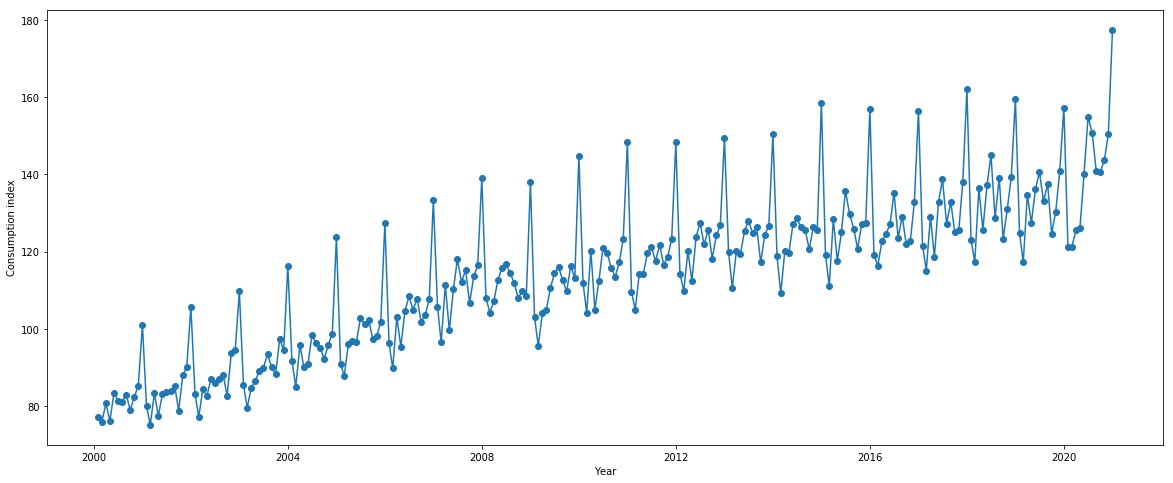

In [16]:
# plot the data
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(varekonsum, marker='o')

# label the axis
plt.xlabel('Year')
plt.ylabel('Consumption index')
plt.show()

* We see monthly oscillation around an upward trend. After 2020 the trend is more irregular and we see sudden spikes in the end of the dataset. Data peaks out every year around the month of December.
* Hence there is trend component, seasonal component, and irregular component.

Note: Page 62 in Taddy - If we had got inscreasing monthly oscillation and noise increasing overtime, we could have changed Y scale to log. Also the consumer index values are positive, hence transforming to log scale could be possible.

#### ii) Construct a dummy variable which has zeros for each month in the sample, but a one for each December month. Call this variable "dum". 

In [17]:
# create an empty list 
dummy = list()

# use for loop to iterate through the months, adding 1 for december and 0 otherwise
for i in range(len(varekonsum)):
    if varekonsum.index.month[i] == 12:
        dummy.append(1)
    else:
        dummy.append(0)

# create dummy variable
varekonsum['dum'] = dummy

# view data
varekonsum.head(25)

,Cons_Index,dum
Date,,
2000-01-31,77.1,0
2000-02-29,75.8,0
2000-03-31,80.7,0
2000-04-30,76.2,0
2000-05-31,83.4,0
2000-06-30,81.4,0
2000-07-31,81.1,0
2000-08-31,83.0,0
2000-09-30,79.0,0


####  iii) Run the following OLS regression:   Yt = B0 + B1*t + B2*dum + et and compute Yt - Yt_hat = et

In [18]:
# construct t 
## pg 62
t= (varekonsum.index.year - min(varekonsum.index.year))*12 + varekonsum.index.month
varekonsum['t'] = t

In [19]:
# define OLS function
def ols(Y,X):
    
    # do OLS
    results = sm.OLS(Y, X).fit()
    estimates = results.params
    summary = results.summary()
    
    # return values
    return summary, estimates

In [20]:
# X and Y for OLS
Y = np.array(varekonsum['Cons_Index']).reshape(-1,1)
X = varekonsum[['t','dum']].to_numpy()

# add ones to X
ones = np.ones((np.shape(X)[0],1))
X = np.hstack((ones,X))

# call OLS function
summary, estimates = ols(Y,X)
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     1093.
Date:                Mon, 15 Mar 2021   Prob (F-statistic):          5.23e-124
Time:                        08:54:03   Log-Likelihood:                -824.57
No. Observations:                 252   AIC:                             1655.
Df Residuals:                     249   BIC:                             1666.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.7705      0.818     99.972      0.000      80.160      83.381
x1             0.2337      0.006     42.034      0.000       0.223       0.245
x2            28.5308      1.463     19.498      0.000      25.649      31.413
==============================================================================
Omnibus:                        4.240   Durbin-Watson:                   1.173
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                4.321
Skew:                          -0.312   Prob(JB):                        0.115
Kurtosis:                       2.848   Cond. No.                         530.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Compute and plot Yt - Yhatt = et. What time series properties would you say are prominent for et? Discuss your answer in relation to question 2i. Why is there a difference?

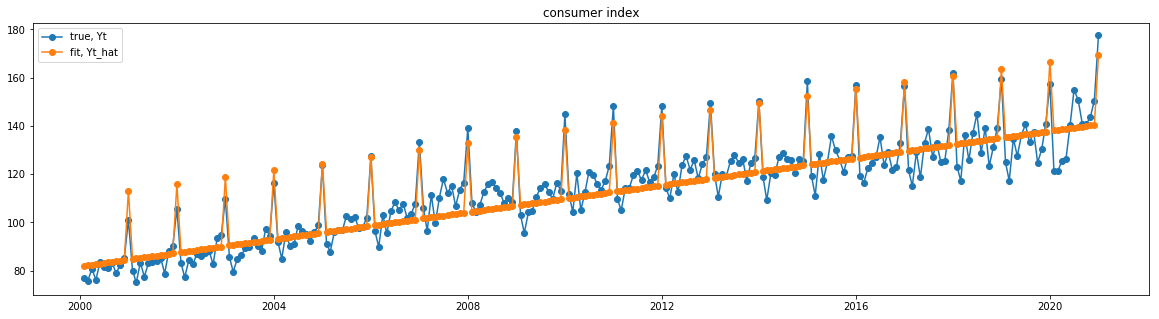

In [21]:
# call OLS another way
cons_model = sm.OLS(Y,X).fit()

# get true y values and change to array 
Yt = varekonsum['Cons_Index']
Yt = np.array(Yt)

# get fitted/predicted y values 
Yt_hat = cons_model.predict()

# create a DataFrame for each of Yt and Yt_hat
Ytdf = pd.DataFrame(Yt)
Yt_hatdf = pd.DataFrame(Yt_hat)
Ytdf.index = pd.date_range(start='31/01/2000', end='31/12/2020', freq='M')
Yt_hatdf.index = pd.date_range(start='31/01/2000', end='31/12/2020', freq='M')

# plot Yt and Yt_hat to see the differenece (residual)
fig, ax = plt.subplots(figsize=(20, 5))

plt.plot(Ytdf, marker='o')
plt.plot(Yt_hatdf, marker='o')

ax.legend(['true, Yt','fit, Yt_hat'])
plt.title("consumer index")

plt.show()

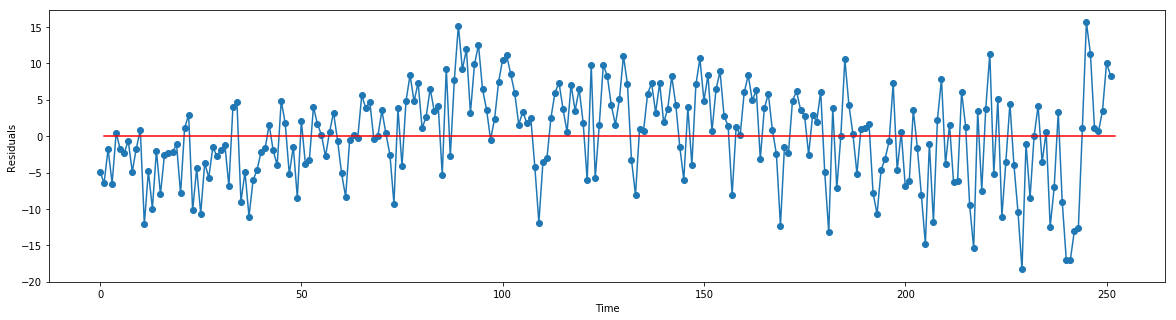

In [22]:
# Compute the error term/noise
eps = Yt - Yt_hat

#plt.plot(Yt, marker='o', linestyle='')
#plt.plot(Yt_hat, marker='o', linestyle='')

# plot residual/error/noise
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(eps, marker='o', linestyle='-')

#plot the mean reverting value
plt.plot([1,len(eps)], [np.mean(eps),np.mean(eps)], color='r')

# label the axis
plt.xlabel('Time')
plt.ylabel('Residuals')

plt.show()

*  We see the error terms are mean reverting (mean = 0) and are stationary. To determine if there is stickiness in the residuals, we did autocorrelation (plot given below). 
* From the plot of autocorrelation for our regression residuals below we see that correlation between Yt and Yt-1 is 0.4 (moderate) while the correlation between Yt and Yt-12 is close to 0.7, which is high. This suggests significant year-on-year seasonal dependence in December month.

Comparing it to question B.i, we see that the plot in B.i is an increasing yearly oscillation around an upward trend. It also has a seasonal component, where the oscillation is highest in December than any other month. 

With an increasing consumer index, the prediction results in more errors, resulting in higher residuals. This is shown more clearly in the plot below as it shows how the noise values get overall further away with most recent year. 

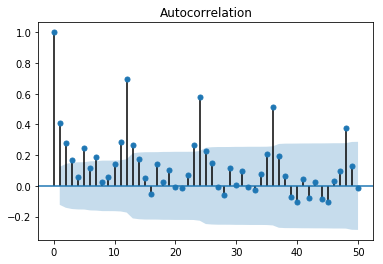

In [23]:
sm.graphics.tsa.plot_acf(eps, ax=None, lags=50)
plt.show()

#### iv) Compute and plot 𝑙𝑜𝑔(𝑌𝑡) ‒ 𝑙𝑜𝑔(𝑌𝑡 ‒ 12), i.e., the year-on-year growth in the 𝑙𝑜𝑔(𝑌𝑡) ‒ 𝑙𝑜𝑔(𝑌𝑡 ‒ 12) data. Call this variable “d12y”. Plot the series. 

In [24]:
# getting the index position to the first occurance of 2001
Yt = np.asarray(varekonsum['Cons_Index'])

# starting at t=12 with the date 2001-01-31 to look at the grwoth from previous year, 2000-01-31
d12y = list()

for i in range(12,len(varekonsum)):
    
    d12y.append(np.log(Yt[i])-np.log(Yt[i-12]))
print(len(d12y))

240


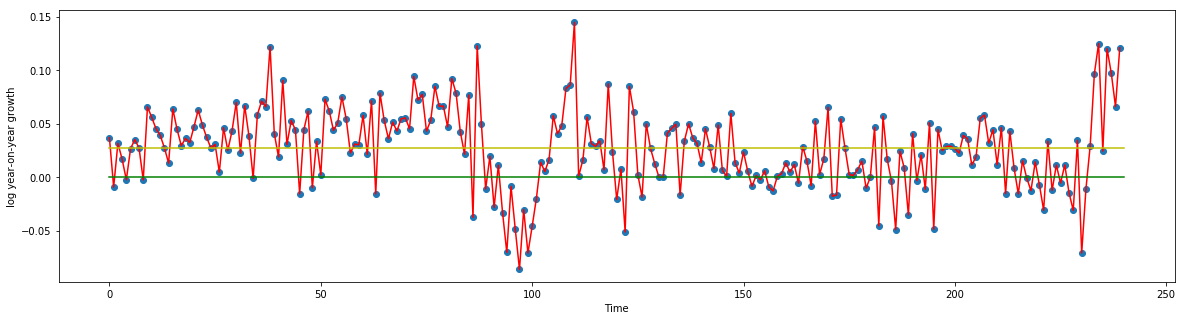

In [25]:
# plot d12y
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(d12y, marker='o', linestyle='')
plt.plot(d12y, linestyle='-', color='r')

#plot a horizontal line at y=0
plt.plot([0,len(d12y)], [0,0], color='g')

#plot the mean reverting value
plt.plot([0,len(d12y)], [np.mean(d12y),np.mean(d12y)], color='y')

# label the axis
plt.xlabel('Time')
plt.ylabel('log year-on-year growth')

plt.show()

#### What time series properties would you say are prominent for d12y? Does the data look stationary and does it have a seasonal component? Explain your answer.

Looking at the plot above, there appears to be no consistent trend over the time span. The series appears to slowly wander up and down. However, it appears that when there is a sharp decline, it is followed with a relatively steep and high incline. From the horizontal line at y=0 (green line), we notice that the series tends to stay above the line for a while and then wanders below it for a relatively short period and increases above the line again. This mean that overall, we have more growth than delcine which is always a good indicaiton in this scenario. 

We can also see that we have a stationary series and does not have a seasonal component. By plotting the mean value, we see that the mean reverting value is ≈ 0.025 (yellow line). 



#### v) Estimate an AR(1) model for d12y. Is the AR model stationary? 

In [26]:
# function to add ones as constant
def addones(array):
    ones = np.ones((np.shape(array)[0],1))    
    array = np.hstack((ones,array))
    return array                                 

# add a constant to the independent X variables for OLS regression
Y = np.asarray(d12y[1:]).reshape(-1,1)
X = addones(np.asarray(d12y[:-1]).reshape(-1,1))


# call OLS function 
results = sm.OLS(Y,X).fit()
estimates = results.params

print('Estimated b0:',estimates[0])
print('Estimated b1:',estimates[1])
print('BIC:', results.bic)

results.summary()

Estimated b0: 0.018014072299068297
Estimated b1: 0.3324555469404676
BIC: -910.2034579768272


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     28.58
Date:                Mon, 15 Mar 2021   Prob (F-statistic):           2.11e-07
Time:                        08:54:04   Log-Likelihood:                 460.58
No. Observations:                 239   AIC:                            -917.2
Df Residuals:                     237   BIC:                            -910.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0180      0.003      6.392      0.000       0.012       0.024
x1             0.3325      0.062      5.346      0.000       0.210       0.455
==============================================================================
Omnibus:                        3.456   Durbin-Watson:                   2.172
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                3.657
Skew:                           0.122   Prob(JB):                        0.161
Kurtosis:                       3.555   Cond. No.                         27.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
def AR_simul(T, b0, b1, μ, σ, y_0):
    
    # initialize the output vector
    Y = np.empty(T+1)
    
    # set the starting value
    Y[0] = y_0
    
    # simulate the AR(1) process
    for i in range(T):
        Y[i+1] = b0 + b1*Y[i] + μ + σ* np.random.randn()
        
        # return the T simulated values without the starting value
    return Y[1:]

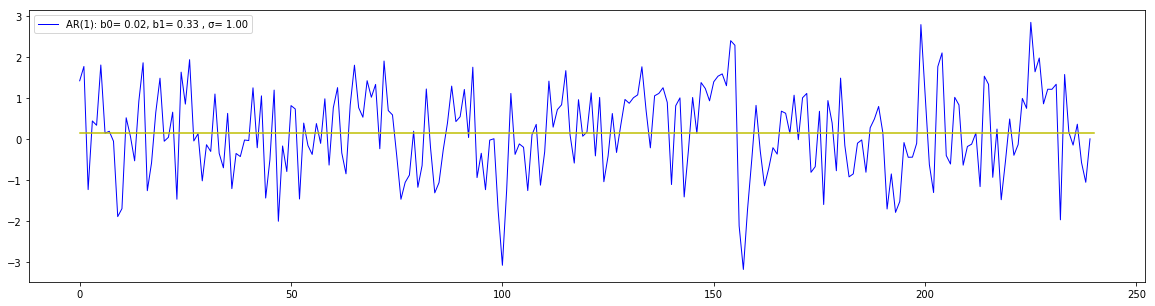

In [28]:
# initialize the coefficients 
T = len(d12y)
b0 = estimates[0]
b1 = estimates[1]
μ = 0
σ = 1
y_0 = 0

# simulate the time-series by calling the simulation function
Y1 = AR_simul(T, b0, b1, μ, σ, y_0)

# plot the simulated time series
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(Y1, 'b-', linewidth=1, label='AR(1): b0= %.2f, b1= %.2f , σ= %.2f' %(b0, b1, σ) )
plt.plot( [0,len(Y1)], [np.mean(Y1),np.mean(Y1)], color='y' )

ax.legend()
plt.show()

* We see that the AR(1) process is stationary since the b1 coefficient is < 1.
* The process is also mean reverting as the values hover around mean of 0.
* AR(1) process shows a lot of noise.

#### Use the BIC to find the optimal lag length for the AR(p) model for d12y. What do you get? 

Hint: If you use the OLS class from the lectures/tutorial, compute the BIC using the formula BIC = n*ln(sigma2) + k*ln(n), where k is the number of variables + 2.

In [29]:
 #AR1
# add a constant to the independent X variables for OLS regression
Y = np.asarray(d12y[1:]).reshape(-1,1)
X = addones(np.asarray(d12y[:-1]).reshape(-1,1))

# call OLS function 
results = sm.OLS(Y,X).fit()
print('BIC:', results.bic)

#results.summary()

BIC: -910.2034579768272


In [30]:
 #AR2                             
# add a constant to the independent X variables for OLS regression
Y = np.asarray(d12y[2:]).reshape(-1,1)
X1 = addones(np.asarray(d12y[1:-1]).reshape(-1,1))
X2 = np.asarray(d12y[:-2]).reshape(-1,1)

X = np.append(X1, X2, axis=1)


# call OLS function 
results = sm.OLS(Y,X).fit()
print('BIC:', results.bic)

#results.summary()

BIC: -924.8933921728905


In [31]:
 #AR3
Y = np.asarray(d12y[3:]).reshape(-1,1)
X1 = addones(np.asarray(d12y[2:-1]).reshape(-1,1))
X2 = np.asarray(d12y[1:-2]).reshape(-1,1)
X3 = np.asarray(d12y[:-3]).reshape(-1,1)

X = np.append(X1, X2, axis=1)
X = np.append(X, X3, axis=1)

# call OLS function 
results = sm.OLS(Y,X).fit()
print('BIC:', results.bic)

BIC: -937.2151765844299


In [32]:
 #AR4
Y = np.asarray(d12y[4:]).reshape(-1,1)
X1 = addones(np.asarray(d12y[3:-1]).reshape(-1,1))
X2 = np.asarray(d12y[2:-2]).reshape(-1,1)
X3 = np.asarray(d12y[1:-3]).reshape(-1,1)
X4 = np.asarray(d12y[:-4]).reshape(-1,1)

X = np.append(X1, X2, axis=1)
X = np.append(X, X3, axis=1)
X = np.append(X, X4, axis=1)

# call OLS function 
results = sm.OLS(Y,X).fit()
print('BIC:', results.bic)


BIC: -927.2267515464896


In [33]:
 #AR5
Y = np.asarray(d12y[5:]).reshape(-1,1)
X1 = addones(np.asarray(d12y[4:-1]).reshape(-1,1))
X2 = np.asarray(d12y[3:-2]).reshape(-1,1)
X3 = np.asarray(d12y[2:-3]).reshape(-1,1)
X4 = np.asarray(d12y[1:-4]).reshape(-1,1)
X5 = np.asarray(d12y[:-5]).reshape(-1,1)

X = np.append(X1, X2, axis=1)
X = np.append(X, X3, axis=1)
X = np.append(X, X4, axis=1)
X = np.append(X, X5, axis=1)

# call OLS function 
results = sm.OLS(Y,X).fit()
print('BIC:', results.bic)


BIC: -920.22284923495


Since we have not used the OLS class from the lectures/tutorial (the hint given), the BIC was found using built-in OLS function. 
As we can see, after computing the BIC from AR(1) up to AR(5), we find that the smallest BIC value is for AR(3). Thus, our optimal lag length for the model d12y is 3. 

# C

In [34]:
# import data
financial_data = pd.read_csv('2018_Financial_Data.csv', sep=',')

# set company name as index
financial_data = financial_data.set_index('Unnamed: 0')

# convert sector to categorical
financial_data["Sector"] = financial_data["Sector"].astype('category')
financial_data["Sector"] = financial_data["Sector"].cat.codes 

In [35]:
financial_data.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
CMCSA,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,1.511100e+10,...,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,2,32.794573,1
KMI,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,2.196000e+09,...,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,4,40.588068,1
INTC,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,...,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,9,30.295514,1
MU,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,1.430300e+10,...,0.4573,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942,9,64.213737,1
GE,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,4.071100e+10,-1.455700e+10,5.059000e+09,-2.177200e+10,...,-0.2781,-0.2892,-0.1575,-0.4487,-0.2297,0.0000,0.0308,7,44.757840,1


In [36]:
# replace missing values with 0
financial_data.fillna(0, inplace=True)

# check for NaN values in dataframe
financial_data.isnull().values.any()

False

#### Constructing X and Y

In [37]:
# Setting dependent variable (Y) as Dividend payments
Y = financial_data['Dividend payments']

# Drop 'Dividend payments' from predictors 
X = financial_data.drop(['Dividend payments'], axis = 1, inplace=False)

#### Standardize the data

The samples could have different means and variances so we should treat them like this.

In [38]:
from sklearn.preprocessing import StandardScaler

# initialize the class
Y_std = StandardScaler()
X_std = StandardScaler()

# compute mean and std. used for computing the z-score
Y_std.fit(Y[:,None])
X_std.fit(X)

# transform the data 
Y_std = Y_std.transform(Y[:,None])
X_std = X_std.transform(X)

C:\Users\kiran\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\kiran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]


#### i) Explain why estimating a OLS regression will fail in this case.

OLS regression will fail in this case: Given the fact that this is financial data with large number of predictors, just by looking at it we can say that several of column values are dependent on other column values. It is highly likely that the regression variables contain multicollinearity.

#### ii) Run a LASSO regression where you choose the penalization parameter using 5-fold cross validation.

In [39]:
# import Lasso with cross-validation
from sklearn.linear_model import LassoCV

# define the LassoCV object
Lasso = LassoCV(cv=5, fit_intercept=False, normalize=False, max_iter=10000).fit(X_std, Y_std.ravel())
print('The optimal alpha is: '+ str(Lasso.alpha_))


The optimal alpha is: 0.019546258457516133


Let's again look at the Lasso paths.

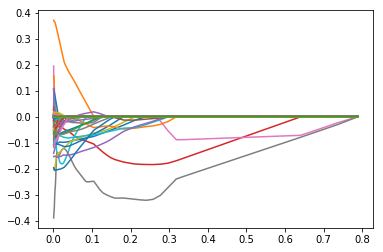

In [40]:
# compute the path
[alphas,weights,c] = Lasso.path(X_std, Y_std.ravel(), max_iter=10000)

# plot the path
fig, ax = plt.subplots()
ax.plot(alphas, weights.T)
plt.show()


#### iii) Explain shortly why cross validation is used in C.ii. Explain shortly why cross validation, and out-of-sample testing in general, is used to avoid in-sample over-fitting.

We use cross validation in C.ii to obtain the Lambda (alpha), which is also called the hyperparameter, with the best score and the associated beta estimates.

By using cross validation & out-of-sample testing we check how well the estimated parameters from training data fit the testing data. If there is overfitting in in-sample data, it is highly likely that we get poor results on out-of-sample data.

#### iv) Make a table showing the regression output. Which predictors are chosen? What is the R-squared of this regression?

#### Estimating the model (implementation with statsmodels)

Table showing the regression output.

In [41]:
# read out the set of remaining features
X_reduced = np.asarray(X)[:,Lasso.coef_ != 0]

# run the regression
model = sm.OLS(Y[:,None], X_reduced)
results = model.fit()

# display output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     719.4
Date:                Mon, 15 Mar 2021   Prob (F-statistic):               0.00
Time:                        08:54:11   Log-Likelihood:                -92684.
No. Observations:                4392   AIC:                         1.854e+05
Df Residuals:                    4361   BIC:                         1.856e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0020      0.002     -1.113      0.266      -0.005       0.002
x2            -0.1336      0.011    -12.159      0.000      -0.155      -0.112
x3            -0.0516      0.012     -4.200      0.000      -0.076      -0.028
x4            -0.1113      0.013     -8.690      0.000      -0.136      -0.086
x5            -0.2341      0.041     -5.679      0.000      -0.315      -0.153
x6            -0.1658      0.031     -5.337      0.000      -0.227      -0.105
x7            -0.8672      0.145     -5.969      0.000      -1.152      -0.582
x8            -0.0073      0.003     -2.167      0.030      -0.014      -0.001
x9         -4.041e+07   3.77e+06    -10.720      0.000   -4.78e+07    -3.3e+07
x10           -0.0607      0.013     -4.656      0.000      -0.086      -0.035
x11           -0.0147      0.001    -14.086      0.000      -0.017      -0.013
x12           -0.0825      0.007    -12.632      0.000      -0.095      -0.070
x13           -0.0038      0.001     -2.977      0.003      -0.006      -0.001
x14           -0.0166      0.005     -3.391      0.001      -0.026      -0.007
x15           -0.0293      0.005     -5.669      0.000      -0.039      -0.019
x16           -0.0246      0.003     -7.906      0.000      -0.031      -0.019
x17           -0.0109      0.001    -12.872      0.000      -0.013      -0.009
x18           -0.0050      0.001     -4.092      0.000      -0.007      -0.003
x19            1.2647      0.039     32.409      0.000       1.188       1.341
x20           -0.0495      0.005     -9.469      0.000      -0.060      -0.039
x21           -0.0225      0.002    -11.635      0.000      -0.026      -0.019
x22           -0.0229      0.003     -7.968      0.000      -0.029      -0.017
x23            0.0009      0.001      1.706      0.088      -0.000       0.002
x24           -0.0191      0.003     -7.149      0.000      -0.024      -0.014
x25        -1.423e+06   5.53e+05     -2.574      0.010   -2.51e+06   -3.39e+05
x26        -1.649e+06   5.91e+05     -2.790      0.005   -2.81e+06    -4.9e+05
x27           -0.0051      0.000    -18.961      0.000      -0.006      -0.005
x28        -1.423e+06   5.53e+05     -2.574      0.010   -2.51e+06   -3.39e+05
x29           -0.0045      0.001     -7.663      0.000      -0.006      -0.003
x30         1.573e+08    6.3e+07      2.497      0.013    3.38e+07    2.81e+08
x31         5.262e+07   3.38e+07      1.557      0.120   -1.37e+07    1.19e+08
x32          1.22e+08   2.94e+07      4.156      0.000    6.44e+07     1.8e+08
==============================================================================
Omnibus:                     4713.068   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4476232.567
Skew:                          -4.454   Prob(JB):                         0.00
Ku

Which predictors are chosen?

In [42]:
for i in range(len(alphas)):
    if alphas[i] == Lasso.alpha_:
        a = weights.T[i,:]
        index_pos = list()
        for i in range(len(a)):
            if a[i] != 0:
                index_pos.append(i)

                
print('Predictors chosen are: \n', list(X.columns[index_pos]))


Predictors chosen are: 
 ['Gross Profit', 'R&D Expenses', 'Earnings before Tax', 'Income Tax Expense', 'Net Income - Non-Controlling int', 'Net Income - Discontinued ops', 'Preferred Dividends', 'Weighted Average Shs Out (Dil)', 'Dividend per Share', 'EBIT', 'Goodwill and Intangible Assets', 'Tax assets', 'Short-term debt', 'Deferred revenue', 'Tax Liabilities', 'Other comprehensive income', 'Retained earnings (deficit)', 'Total shareholders equity', 'Stock-based compensation', 'Acquisitions and disposals', 'Investing Cash flow', 'Issuance (repayment) of debt', 'Financing Cash Flow', 'Free Cash Flow', 'payoutRatio', 'dividendPayoutRatio', 'Enterprise Value', 'Payout Ratio', 'Average Payables', '10Y Operating CF Growth (per Share)', '5Y Operating CF Growth (per Share)', '5Y Shareholders Equity Growth (per Share)']


R-squared

In [43]:
# R-squared value of the regression
results.rsquared

0.8364454191507207

#### v) Use all predictors and compute 1 common component using PCA. Plot this common component.

Use all predictors and compute 1 common component using PCA

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(X_std)

pca = pca.transform(X_std)
df = pd.DataFrame(pca, columns=['PCA'])

df.head()

,PCA
0,35.955524
1,5.509405
2,25.278391
3,11.142088
4,7.099544


Plot this common component.

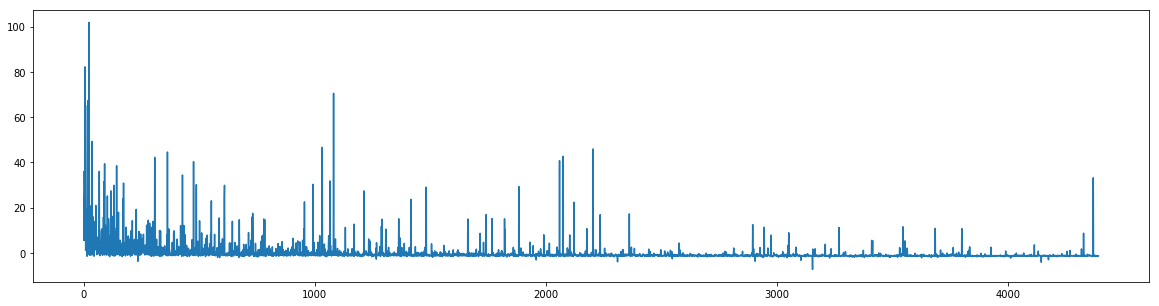

In [45]:
# plot the common component
plt.figure(figsize=(20,5)) 
plt.plot(pca)
plt.show()

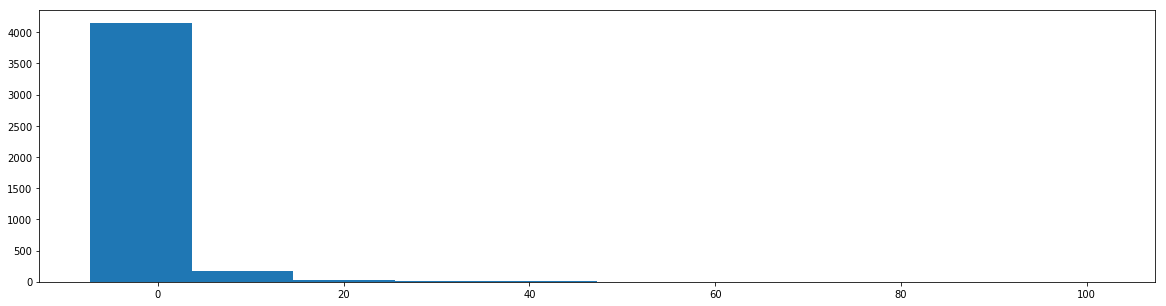

In [46]:
# histogram of the common component
plt.figure(figsize=(20,5)) 
plt.hist(pca)
plt.show()

Comment: 

In our original dataset there were many rows under the column 'Dividend payments' that had NaN that was replaced by zero values. After standardizing this data (described by column Y_std), these zero values were replaced by a number (as can be seen below that some values are 0.22278853). This replacement is depicted in the above histogram. Hence, the frequency of the first bin is so high.

In [47]:
Y_std

array([[-3.7034562 ],
       [-1.67239762],
       [-6.26746267],
       ...,
       [ 0.22278853],
       [ 0.22278853],
       [ 0.22278853]])

#### vi) Regress the outcome variable on the common component. What is the R-squared of this regression? Compare your result with what you got in C.iv.

In [48]:
np.shape(pca)

(4392, 1)

In [51]:
# run the regression
model = sm.OLS(Y_std, pca)
results = model.fit()

# display output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     6733.
Date:                Mon, 15 Mar 2021   Prob (F-statistic):               0.00
Time:                        08:54:29   Log-Likelihood:                -4190.6
No. Observations:                4392   AIC:                             8383.
Df Residuals:                    4391   BIC:                             8390.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1590      0.002    -82.056      0.000      -0.163      -0.155
==============================================================================
Omnibus:                     4061.187   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1155567.323
Skew:                          -3.692   Prob(JB):                         0.00
Kurtosis:                      82.120   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared

In [50]:
# R-squared value of the regression
results.rsquared

0.6052753069622929

In C.iv we got a greated R-squared of value = 0.8364454191507188 which is more than what we got in this exercise. The R-squared is interpreted as how well the regression fits the model, with a higher R-squared value meaning a better fit, or said differently, less errors. This means that from the R-sqaured values we got, the predictors using LASSO in C.iv are a better fit that the common component using PCA in this exercise.

#### vii. In light of your answer in C.vi, discuss shortly in which cases using PCA versus LASSO might be beneficial.

Principal Component Analysis (PCA) is a clustering strategy. It is an unsupervised learning algorithm and is a way of reducing the dimension of our data by transforming a large data set into a smaller one that contains most relevant information. The Least Absolute Shrinkage and Selection Operator (LASSO) is a regularisation strategy. It is a supervised learning algorithm and it aims to alleviate the overfitting problem by introducing bias, hence enhancing the prediction accuracy. 
Said simply, LASSO leads to minimising or dropping predictors whereas PCA is about clustering them.

We use LASSO when we want our model to work on other data sets, or out-of-sample (OOS) data. This is because some of the estimated coefficients values will be exactly equal to zero, making them work better on new data sets. It is great to use when we have many predictors and want to select only a few as it implicitly performs dimension reduction. PCA on the other hand is used when we are handling high-dimensional problems where many variables are highly correlated, i.e., capturing the same underlying phenomenon, for example when establishing group memberships. 
